In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
%load_ext autoreload
%autoreload 2

In [39]:
import edesdetectrl.config as general_config
from mlflow.tracking import MlflowClient
import mlflow

#client = MlflowClient(general_config.config["mlflow"]["tracking_uri"])
client = MlflowClient("/itf-fi-ml/home/magnukva/mlflow")

In [2]:
# Color palette
pink = "#FF00C0"
purple = "#9401FF"
dark_blue = "#4900FF"
blue = "#01B9FF"
cyan = "#00FFF9"

# Training Curves

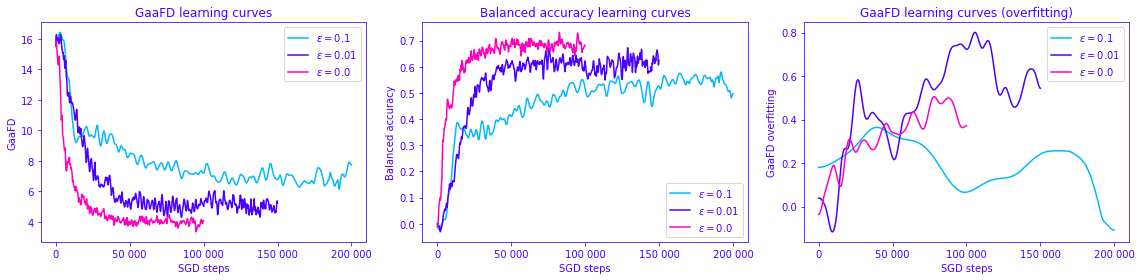

In [46]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

run_ids = [
    "1689914533b246cb9359d9a36f0a0c16",
    "a98f4ed479584cb7b3851da70ec1e817",
    "a122209d719141d7a45255d2bdb5a65b",
]


def get_metrics(name, max_steps, sigma=4):
    hist = client.get_metric_history(run_id, name)
    hist = [m for m in hist if m.step <= max_steps]
    steps = [m.step for m in hist]
    values = [m.value for m in hist]
    values = gaussian_filter1d(values, sigma)
    return steps, values


fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
colors = [blue, dark_blue, pink]
max_stepss = [200_000, 150_000, 100_000]
for run_id, color, max_steps in zip(run_ids, colors, max_stepss):
    val_steps, val_values = get_metrics("VAL_gaafd", max_steps)
    ax[0].plot(val_steps, val_values, c=color)
    train_steps, train_values = get_metrics("TRAIN_gaafd", max_steps)
    diff = val_values-np.interp(val_steps, train_steps, train_values)
    diff = gaussian_filter1d(diff, 50)
    ax[2].plot(val_steps, diff, c=color)

    steps, values = get_metrics("VAL_balanced_accuracy", max_steps)
    ax[1].plot(steps, values, c=color)

ax[0].set_title("GaaFD learning curves", c=dark_blue)
ax[0].set_ylabel("GaaFD", c=dark_blue)
ax[0].set_xlabel("SGD steps", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.01$", "$\epsilon =0.0$"], labelcolor=dark_blue
)
ax[1].set_title("Balanced accuracy learning curves", c=dark_blue)
ax[1].set_ylabel("Balanced accuracy", c=dark_blue)
ax[1].set_xlabel("SGD steps", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.01$", "$\epsilon =0.0$"], labelcolor=dark_blue
)
ax[2].set_title("GaaFD learning curves (overfitting)", c=dark_blue)
ax[2].set_ylabel("GaaFD overfitting", c=dark_blue)
ax[2].set_xlabel("SGD steps", c=dark_blue)
ax[2].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.01$", "$\epsilon =0.0$"], labelcolor=dark_blue
)

for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()


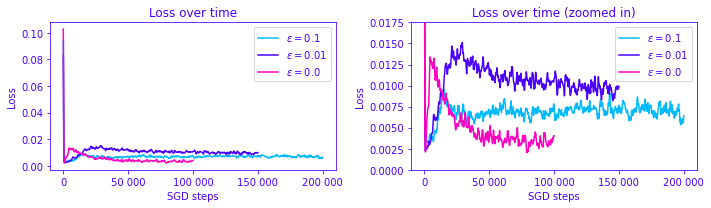

In [43]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

run_ids = [
    "1689914533b246cb9359d9a36f0a0c16",
    "a98f4ed479584cb7b3851da70ec1e817",
    "a122209d719141d7a45255d2bdb5a65b",
]

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
colors = [blue, dark_blue, pink]
max_stepss = [200_000, 150_000, 100_000]
for run_id, color, max_steps in zip(run_ids, colors, max_stepss):
    val_steps, val_values = get_metrics("total_loss", max_steps)
    ax[0].plot(val_steps, val_values, c=color)
    ax[1].plot(val_steps, val_values, c=color)

ax[0].set_title("Loss over time", c=dark_blue)
ax[0].set_ylabel("Loss", c=dark_blue)
ax[0].set_xlabel("SGD steps", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.01$", "$\epsilon =0.0$"], labelcolor=dark_blue
)
ax[1].set_title("Loss over time (zoomed in)", c=dark_blue)
ax[1].set_ylabel("Loss", c=dark_blue)
ax[1].set_xlabel("SGD steps", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.01$", "$\epsilon =0.0$"], labelcolor=dark_blue
)
ax[1].set_ylim([0.0, 0.0175])

for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()


Testing GaaFD models with different values of epsilon:
- Percentage of videos with different number of event-predictions as ground truth
- aaFD of videos with correct number of predictions
- GaaFD overall
- Distribution of frame difference (potentially both negative and positive)
- GaaFD for Diastolic and Systolic events
- Overfitting (TRAIN versus TEST)
- Show Q-values for good predicted video and bad predicted video

Store result: (TRAIN and TEST) + Predictions + ground truth + filename

[167336, 136996, 95616]

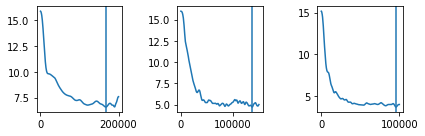

In [6]:
# Find the best model for each run
fig, ax = plt.subplots(ncols=3, figsize=(6, 2))
best_model_steps = []
for i, run_id, max_steps in zip(range(len(run_ids)), run_ids, max_stepss):
    val_steps, val_values = get_metrics("VAL_gaafd", max_steps, sigma=20)
    best_model_i = np.argmin(val_values)
    best_model_steps.append(val_steps[best_model_i])
    ax[i].axvline(val_steps[best_model_i])
    ax[i].plot(val_steps, val_values)
fig.tight_layout()
best_model_steps

In [7]:
for k in range(3):
    run_id = run_ids[k]
    best_model_step = best_model_steps[k]
    for artifact in client.list_artifacts(run_id):
        if artifact.path[7:] == str(best_model_step):
            print(artifact.path)
            break

params_167336
params_136996
params_95616


In [12]:
import notebooks.plots.results.bce.helpers as helpers
import pickle

train_trajectories = []
for params_path in [
    "notebooks/plots/results/bce/gaafd/models/epsilon_01",
    "notebooks/plots/results/bce/gaafd/models/epsilon_001",
    "notebooks/plots/results/bce/gaafd/models/epsilon_0",
]:
    train_trajectories.append(helpers.evaluate_with_params(params_path, "TRAIN"))

with open("train_trajectories", "wb+") as f:
    pickle.dump(train_trajectories, f)

test_trajectories = []
for params_path in [
    "notebooks/plots/results/bce/gaafd/models/epsilon_01",
    "notebooks/plots/results/bce/gaafd/models/epsilon_001",
    "notebooks/plots/results/bce/gaafd/models/epsilon_0",
]:
    test_trajectories.append(helpers.evaluate_with_params(params_path, "TEST"))

with open("test_trajectories", "wb+") as f:
    pickle.dump(test_trajectories, f)

100%|██████████| 1012/1012 [02:46<00:00,  6.07it/s]


In [3]:
import pickle

with open("notebooks/plots/results/bce/gaafd/trajectories/train_trajectories", "rb") as f:
    train_trajectories =pickle.load(f)
with open("notebooks/plots/results/bce/gaafd/trajectories/test_trajectories", "rb") as f:
    test_trajectories =pickle.load(f)

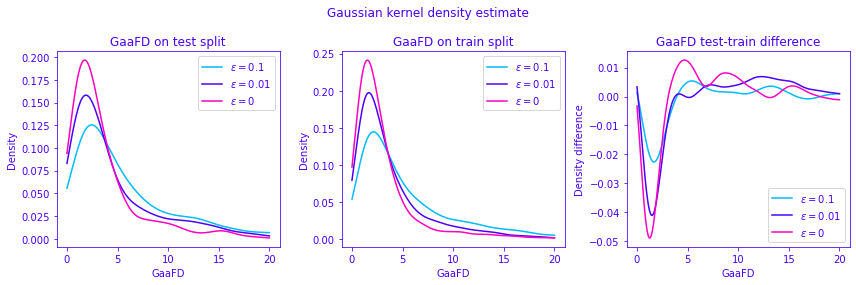

In [52]:
from edesdetectrl.environments import Trajectory, TrajectoryItem
from edesdetectrl.core.metrics import gaafd
from scipy import stats
import numpy as np
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt


def gaafd_density(
    x: np.ndarray, trajectories: Dict[str, Tuple[List, List]], label=None, bw_method=None
):
    gaafds = []
    for filename, (gt, predictions) in trajectories.items():
        val = gaafd(gt, predictions, label=label)
        gaafds.append(val)
    density = stats.kde.gaussian_kde(gaafds, bw_method=bw_method)
    #print(np.mean(gaafds))
    return density(x)

colors = [blue, dark_blue, pink]
x = np.linspace(0, 20, 200)
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i, (test_traj, train_traj) in enumerate(zip(test_trajectories, train_trajectories)):
    ax[0].plot(x, gaafd_density(x, test_traj, bw_method=None), c=colors[i])
    ax[1].plot(x, gaafd_density(x, train_traj, bw_method=None), c=colors[i])
    ax[2].plot(
        x, gaafd_density(x, test_traj, bw_method=None) - gaafd_density(x, train_traj, bw_method=None), c=colors[i]
    )

ax[0].set_title("GaaFD on test split", c=dark_blue)
ax[0].set_ylabel("Density", c=dark_blue)
ax[0].set_xlabel("GaaFD", c=dark_blue)
ax[0].legend(
    ["$\epsilon=0.1$", "$\epsilon=0.01$", "$\epsilon=0$"], labelcolor=dark_blue
)
ax[1].set_title("GaaFD on train split", c=dark_blue)
ax[1].set_ylabel("Density", c=dark_blue)
ax[1].set_xlabel("GaaFD", c=dark_blue)
ax[1].legend(
    ["$\epsilon=0.1$", "$\epsilon=0.01$", "$\epsilon=0$"], labelcolor=dark_blue
)
ax[2].set_title("GaaFD test-train difference", c=dark_blue)
ax[2].set_ylabel("Density difference", c=dark_blue)
ax[2].set_xlabel("GaaFD", c=dark_blue)
ax[2].legend(
    ["$\epsilon=0.1$", "$\epsilon=0.01$", "$\epsilon=0$"], labelcolor=dark_blue
)
fig.suptitle("Gaussian kernel density estimate", c=dark_blue)
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()


# GaaFD Scores
- $\epsilon=0$
  - TRAIN: 3.30
  - TEST: 3.68
- $\epsilon=0.01$
  - TRAIN: 4.17
  - TEST: 4.59
- $\epsilon=0.1$
  - TRAIN: 5.61
  - TEST: 5.84

NameError: name 'gaafd_density' is not defined

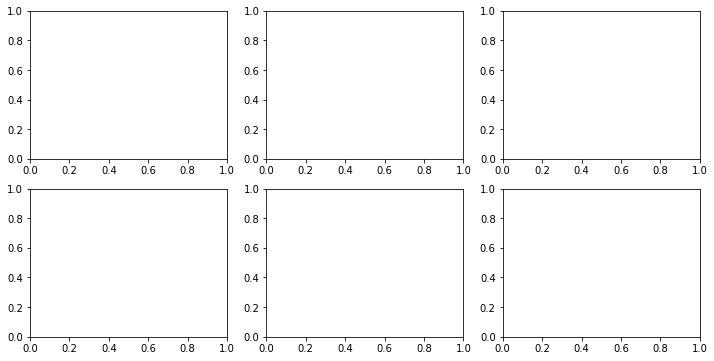

In [52]:
colors = [blue, dark_blue, pink]
x = np.linspace(0, 20, 200)
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(12, 6))
for i, (test_traj, train_traj) in enumerate(zip(test_trajectories, train_trajectories)):
    ed_gaafd_test = gaafd_density(x, test_traj, label=0, bw_method=None)#0.02)
    es_gaafd_test = gaafd_density(x, test_traj, label=1, bw_method=None)#0.02)
    ed_gaafd_train = gaafd_density(x, train_traj, label=0, bw_method=None)#0.02)
    es_gaafd_train = gaafd_density(x, train_traj, label=1, bw_method=None)#0.02)

    ax[0, i].plot(x, ed_gaafd_test, c=colors[i])
    ax[0, i].plot(x, es_gaafd_test, linestyle="dashed", c=colors[i])
    ax[0, i].legend(["ED", "ES"], labelcolor=dark_blue)
    ax[1, i].plot(x, ed_gaafd_test-ed_gaafd_train, c=colors[i])
    ax[1, i].plot(x, es_gaafd_test-es_gaafd_train, linestyle="dashed", c=colors[i])
    ax[1, i].legend(["ED", "ES"], labelcolor=dark_blue)

ax[0,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[0,0].set_ylabel("Density", c=dark_blue)
ax[0,0].set_xlabel("GaaFD", c=dark_blue)
ax[0,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[0,1].set_ylabel("Density", c=dark_blue)
ax[0,1].set_xlabel("GaaFD", c=dark_blue)
ax[0,2].set_title("$\epsilon=0$", c=dark_blue)
ax[0,2].set_ylabel("Density", c=dark_blue)
ax[0,2].set_xlabel("GaaFD", c=dark_blue)
ax[1,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[1,0].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,0].set_xlabel("GaaFD", c=dark_blue)
ax[1,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[1,1].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,1].set_xlabel("GaaFD", c=dark_blue)
ax[1,2].set_title("$\epsilon=0$", c=dark_blue)
ax[1,2].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,2].set_xlabel("GaaFD", c=dark_blue)
#for i in range(3):
#    ax[0,i].set_ylim([0,0.18])
#    ax[1,i].set_ylim([-0.053,0.016])
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

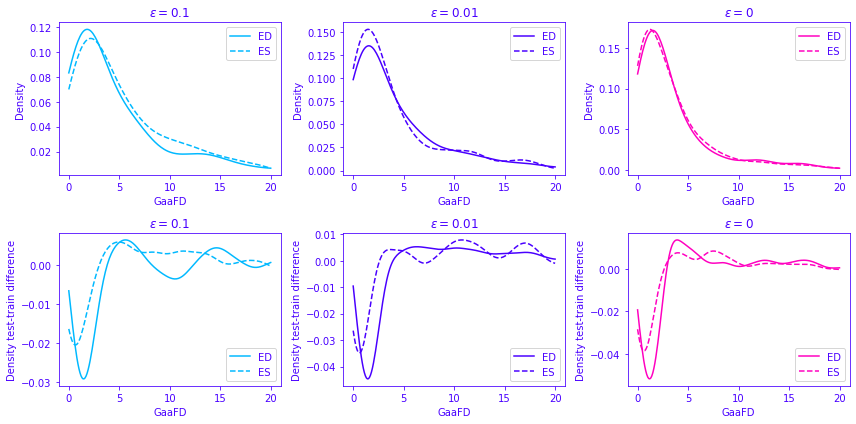

In [54]:
colors = [blue, dark_blue, pink]
x = np.linspace(0, 20, 200)
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(12, 6))
for i, (test_traj, train_traj) in enumerate(zip(test_trajectories, train_trajectories)):
    ed_gaafd_test = gaafd_density(x, test_traj, label=0, bw_method=None)
    es_gaafd_test = gaafd_density(x, test_traj, label=1, bw_method=None)
    ed_gaafd_train = gaafd_density(x, train_traj, label=0, bw_method=None)
    es_gaafd_train = gaafd_density(x, train_traj, label=1, bw_method=None)

    ax[0, i].plot(x, ed_gaafd_test, c=colors[i])
    ax[0, i].plot(x, es_gaafd_test, linestyle="dashed", c=colors[i])
    ax[0, i].legend(["ED", "ES"], labelcolor=dark_blue)
    ax[1, i].plot(x, ed_gaafd_test-ed_gaafd_train, c=colors[i])
    ax[1, i].plot(x, es_gaafd_test-es_gaafd_train, linestyle="dashed", c=colors[i])
    ax[1, i].legend(["ED", "ES"], labelcolor=dark_blue)

ax[0,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[0,0].set_ylabel("Density", c=dark_blue)
ax[0,0].set_xlabel("GaaFD", c=dark_blue)
ax[0,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[0,1].set_ylabel("Density", c=dark_blue)
ax[0,1].set_xlabel("GaaFD", c=dark_blue)
ax[0,2].set_title("$\epsilon=0$", c=dark_blue)
ax[0,2].set_ylabel("Density", c=dark_blue)
ax[0,2].set_xlabel("GaaFD", c=dark_blue)
ax[1,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[1,0].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,0].set_xlabel("GaaFD", c=dark_blue)
ax[1,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[1,1].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,1].set_xlabel("GaaFD", c=dark_blue)
ax[1,2].set_title("$\epsilon=0$", c=dark_blue)
ax[1,2].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,2].set_xlabel("GaaFD", c=dark_blue)
# for i in range(3):
#    ax[0,i].set_ylim([0,0.18])
#    ax[1,i].set_ylim([-0.053,0.016])
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

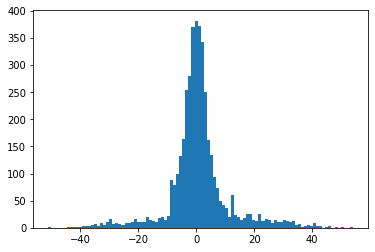

In [178]:
from edesdetectrl.core.metrics import frame_diffs

trajectories = test_trajectories[0]
diffs = []
for filename, (gt, predictions) in trajectories.items():
    gt_diffs, pred_diffs = frame_diffs(gt, predictions)
    diffs += gt_diffs
    diffs += pred_diffs
density = stats.kde.gaussian_kde(diffs)

x = np.linspace(-20,20,200)
plt.hist(diffs, bins=100)
None


# Correct number of predictions

Valid aaFD: 3.51171875
Valid aaFD: 2.708067940552017
Valid aaFD: 2.431777378815081


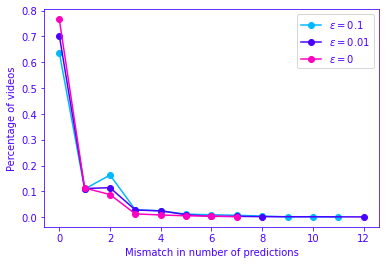

In [51]:
from edesdetectrl.core.metrics import get_events, gaafd
import numpy as np

def valid_aafd(trajectories):
    aafds = []
    n = 0
    event_diffs = []
    for filename, (gt, preds) in trajectories.items():
        gt_events = [e for e in get_events(gt)]
        pred_events = [e for e in get_events(preds)]
        event_diffs.append(np.abs(len(gt_events) - len(pred_events)))
        if len(gt_events) != len(pred_events):
            n+=1
        else:
            aafds.append(gaafd(gt, preds))
    return event_diffs, 1-n/len(trajectories), aafds


colors = [blue, dark_blue, pink]
fig, ax = plt.subplots(ncols=1, figsize=(6,4))
for i, trajectories in enumerate(test_trajectories):
    event_diffs, p_valid, aafds = valid_aafd(trajectories)
    print("Valid aaFD:", np.mean([aafd for d, aafd in zip(event_diffs, aafds) if d == 0]))
    ys_, xs_ = np.histogram(event_diffs, range(120))
    xs_ = xs_[:-1]
    xs, ys = [], []
    for j, y in enumerate(ys_):
        if y != 0:
            ys.append(y)
            xs.append(xs_[j])
    plt.plot(xs, np.array(ys)/len(trajectories), "o-", c=colors[i])

plt.legend(["$\epsilon=0.1$", "$\epsilon=0.01$", "$\epsilon=0$"], labelcolor=dark_blue)
plt.ylabel("Percentage of videos", color=dark_blue)
plt.xlabel("Mismatch in number of predictions", color=dark_blue)
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)

# Representative Q-values

In [ ]:
for params_path in [
    "notebooks/plots/results/bce/gaafd/models/epsilon_01",
    "notebooks/plots/results/bce/gaafd/models/epsilon_001",
    "notebooks/plots/results/bce/gaafd/models/epsilon_0",
]:
    pass

In [53]:
gaafd_sorted = []
for i, trajectories in enumerate(test_trajectories):
    res = sorted(
        [
            (filename, gaafd(gt, predictions))
            for filename, (gt, predictions) in trajectories.items()
        ],
        key=lambda item: item[1],
    )
    gaafd_sorted.append(res)



In [112]:
# TODO: Q-values of best videos and worst videos
filename, score = gaafd_sorted[0][60]
key = filename.split("/")[-1]
key


'0X334F8452094FF33E.avi'

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


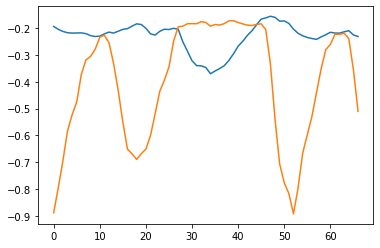

In [113]:
import edesdetectrl.util.dm_env as util_dm_env
from acme import specs
from edesdetectrl.dataloaders.echonet import Echonet
from edesdetectrl.environments.vanilla_binary_classification import (
    VanillaBinaryClassificationBase_v0,
)
from edesdetectrl.nets import simple_dqn_network, transform
from jax import random

from edesdetectrl.dataloaders.echonet import Echonet

echonet = Echonet(None)
f, args = echonet[key]
data_item = f(*args)

params_path = "notebooks/plots/results/bce/gaafd/models/epsilon_0"
base_env = VanillaBinaryClassificationBase_v0("simple")
env = util_dm_env.GymWrapper(base_env)
env_spec = specs.make_environment_spec(env)
network = transform(env_spec, simple_dqn_network(env_spec))
with open(params_path, "rb") as f:
    params, state = pickle.load(f)
rng_key = random.PRNGKey(1337)


episode_batch = np.empty((len(data_item.ground_truth), 112, 112, 7))
for i, gt in enumerate(data_item.ground_truth):
    frame_index = data_item.ground_truth_start + i
    frames = data_item.video[frame_index - 3 : frame_index + 4]
    episode_batch[i] = np.transpose(frames, [1, 2, 0])
    #frames = np.expand_dims(np.transpose(frames, [1, 2, 0]), 0)
q_values, state = network.apply(params, state, rng_key, episode_batch)

plt.plot(q_values[:,0])
plt.plot(q_values[:,1])
print(data_item.ground_truth)